<a href="https://colab.research.google.com/github/fedhere/DSPS_FBianco/blob/main/Labs/diymcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Simple-line-fit-with-MCMC" data-toc-modified-id="Simple-line-fit-with-MCMC-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple line fit with MCMC</a></div><div class="lev1 toc-item"><a href="#Model:-a-line-mx-+-b" data-toc-modified-id="Model:-a-line-mx-+-b-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model: a line <em>mx + b</em></a></div><div class="lev1 toc-item"><a href="#prior" data-toc-modified-id="prior-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>prior</a></div><div class="lev1 toc-item"><a href="#likelihood" data-toc-modified-id="likelihood-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>likelihood</a></div><div class="lev1 toc-item"><a href="#DYI-Metropolis-Hasting" data-toc-modified-id="DYI-Metropolis-Hasting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DYI Metropolis Hasting</a></div><div class="lev2 toc-item"><a href="#Run-the-code-with-different-chain-lengths-to-see-how-the-MCMC-explores-the-parameter-space" data-toc-modified-id="Run-the-code-with-different-chain-lengths-to-see-how-the-MCMC-explores-the-parameter-space-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Run the code with different chain lengths to see how the MCMC explores the parameter space</a></div><div class="lev1 toc-item"><a href="#Affine-Invariant-MCMC-sample-(with-emcee)" data-toc-modified-id="Affine-Invariant-MCMC-sample-(with-emcee)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Affine Invariant MCMC sample (with emcee)</a></div><div class="lev1 toc-item"><a href="#Comparison-with-analytical-solution" data-toc-modified-id="Comparison-with-analytical-solution-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Comparison with analytical solution</a></div><div class="lev1 toc-item"><a href="#Test-convergence-by-looking-at-the-autocorrelation" data-toc-modified-id="Test-convergence-by-looking-at-the-autocorrelation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Test convergence by looking at the autocorrelation</a></div><div class="lev1 toc-item"><a href="#Increase-the-steps-in-the-chain" data-toc-modified-id="Increase-the-steps-in-the-chain-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Increase the steps in the chain</a></div>

# Simple line fit with MCMC

In [1]:
!pip install corner

In [2]:
!pip install emcee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.0 MB/s eta 0:00:00


In [3]:
from __future__ import print_function, division
import pylab as pl
import  corner
import emcee
import scipy
from scipy.stats import norm

%pylab inline

pl.rcParams['figure.figsize']= (10,10)
pl.rcParams['font.size'] = 18

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Model: a line *mx + b*

In [4]:
def line(m, b, x):
    return m * x + b

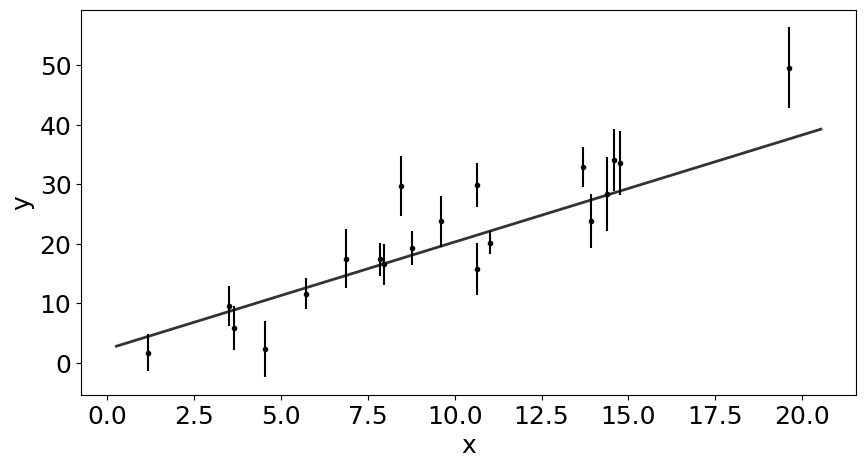

Figure 1: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors


In [18]:
# Choose the "true" parameters.
m_true = 1.8
b_true = 2.3

# Generate some synthetic data from the model.
N = 20
np.random.seed(123)
x = np.sort(np.random.rand(N) * 20)
y = line(m_true, b_true, x)
yerr = np.sqrt(y) + np.random.randn(N)
y += yerr * np.random.randn(N)

ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-', alpha=0.8, lw=2)

pl.show()
print ("Figure 1: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors")

To get

$P(\theta \mid D,f)$

from Bayes theorem

$P(\theta \mid D,f)\quad \propto { { \quad P(D\mid \theta ,f)\, P(\theta ,f) } } $

I need $ { { \quad P(D\mid \theta ,f)\, P(\theta ,f) } } $

NEXT STEP: define Prior $ P(\theta ,f)$ and Likelihood $\quad P(D\mid \theta ,f)$

# prior

In [64]:
# what do I know about my model? e.g. the slope should be between 0 and 90 degree
def lnprior(theta):
    m, b = theta
    if -10 < b < 10 and 0 < m < 10 :
        return 0.0
    return -np.inf

# likelihood

In [65]:
#remember the chi square:
# Sum((model - data)/error)^2 is a quantity that follows a chi square distribution with N=number of degreed of freedom.
# Divide it by the number of degreed  of freedom as Chisq = (Sum((model - data)/error)^2)/DOF
# If it is ~1 that is a good model.
# >1 bad model
# <1 your errors must be underestimated (model too good to be true!)

def lnlike(theta, x, y, yerr):
    m, b = theta
    return -0.5*(np.sum((line(m, b, x) - y)**2 / (yerr**2)))

# DYI Metropolis Hasting

In [8]:
#first pass

np.random.seed(666)
theta_current = (m_true, b_true) + np.random.randn(2) #move the initial guess slightly
print("theta_0 = ", theta_current)
walk = [theta_current]

#the new position is proposed as a random displacement over the current position
proposal_width = (0.2, 0.2)
proposal = scipy.stats.norm(theta_current, proposal_width).rvs()
print("theta_1 = ", proposal)

#calculate the likelihood at current and proposed position
lnpost_current =  lnlike(theta_current, x, y, yerr) + lnprior(theta_current)
print(lnpost_current)
lnpost_proposal =  lnlike(proposal, x, y, yerr) + lnprior(proposal)
print(lnpost_proposal)


theta_0 =  [2.62418808 2.779966  ]
theta_1 =  [2.85888169 2.96177562]
-52.80280241581931
-84.1863619955718


In [9]:
#now repeat including the walk
np.random.seed(666)

theta_current = (m_true, b_true) + np.random.randn(2)

# we start the walk here
walk = [theta_current]

# proposed perturbation of the current position - gaussian with width 0.5
proposal_width = (0.2, 0.2)
proposal = scipy.stats.norm(theta_current, proposal_width).rvs()

# current values of the pieces of Bayes theorem
lnlik_current = lnlike(theta_current, x, y, yerr)
lnprior_current = lnprior(theta_current)

# values of the pieces of Bayes theorem at the proposed position
lnlik_proposal  = lnlike(proposal, x, y, yerr)
lnprior_proposal = lnprior(proposal)

# put them together
p_current = np.exp(lnlik_current + lnprior_current)
p_proposal = np.exp(lnlik_proposal + lnprior_proposal)
print("p current {:.2g}".format(p_current))
print("p new {:.2g}".format(p_proposal))


p current 1.2e-23
p new 2.7e-37


## Run the chain to see how the MCMC explores the parameter space
The simple algorithm coded below runs an MCMC with a single chain. The length of the chain is controlled by the parameter N


In [10]:
N = 10_000 #number of steps in my chain

# move along the walk N = 100, 1000 steps
np.random.seed(666)

theta_current = (m_true, b_true) + np.random.randn(2)

# we start the walk here
walk = [theta_current]

# propoed perturbation of the current position - gaussian with width 0.5
proposal_width = (0.2, 0.2)

# current values  of the pieces of Bayes theorem
lnlik_current = lnlike(theta_current, x, y, yerr)
lnprior_current = lnprior(theta_current)

lnpost_current = lnlik_current + lnprior_current

for i in range(N):

    # calculate the proposal and the prior  and likelihood there
    proposal = scipy.stats.norm(theta_current, proposal_width).rvs()
    lnlik_proposal  = lnlike(proposal, x, y, yerr)
    lnprior_proposal = lnprior(proposal)
    lnpost_proposal = lnlik_proposal + lnprior_proposal

    # update for sure if it is a better location
    if lnpost_proposal > lnpost_current:
        #print ("right away")
        theta_current, lnlik_current, lnprior_current, lnpost_current = \
        proposal, lnlik_proposal, lnprior_proposal, lnpost_proposal
        walk.append(proposal)

    #update with a probability equal to the posteriors ratio if the location is worse
    else:
        p_accept = (lnpost_proposal / lnpost_current)

        #use a stocastic draw to accept with probability P
        if np.random.rand() < p_accept:
            #print ("accepted ")
          theta_current, lnlik_current, lnprior_current, lnpost_current = \
          proposal, lnlik_proposal, lnprior_proposal, lnpost_proposal
          walk.append(proposal)
m_mcmc = np.percentile(np.array(walk)[:,0], [50, 16, 84])
b_mcmc = np.percentile(np.array(walk)[:,1], [50, 16, 84])
mcmcRes = np.concatenate([m_mcmc, b_mcmc])
print ("MCMC result:\nslope\t\t{0:+.2f} ({1:.2f}, {2:.2f})\nintercept\t{3:.2f} ({4:.2f}, {5:.2f})".format(*mcmcRes))

/tmp/ipython-input-2181752040.py:37: RuntimeWarning: invalid value encountered in scalar divide
  p_accept = (lnpost_proposal / lnpost_current)


MCMC result:
slope		+3.12 (0.87, 5.96)
intercept	-3.82 (-8.52, -0.16)


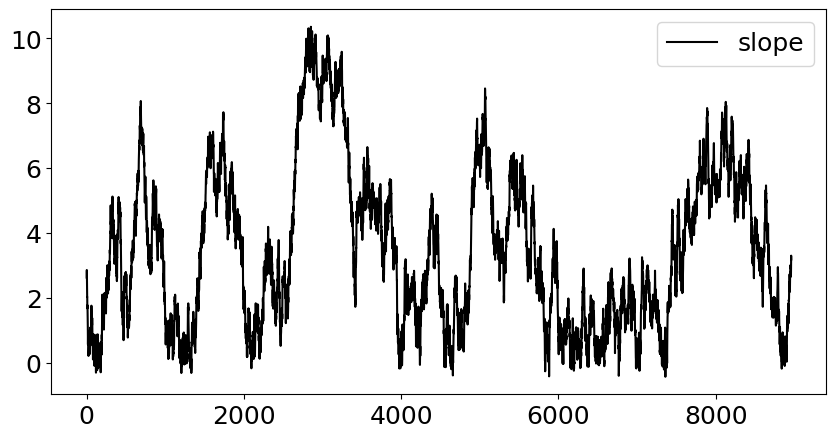

Fig 2:  slope MCMC chain: the positions explored in the slope direction of the posterior surface


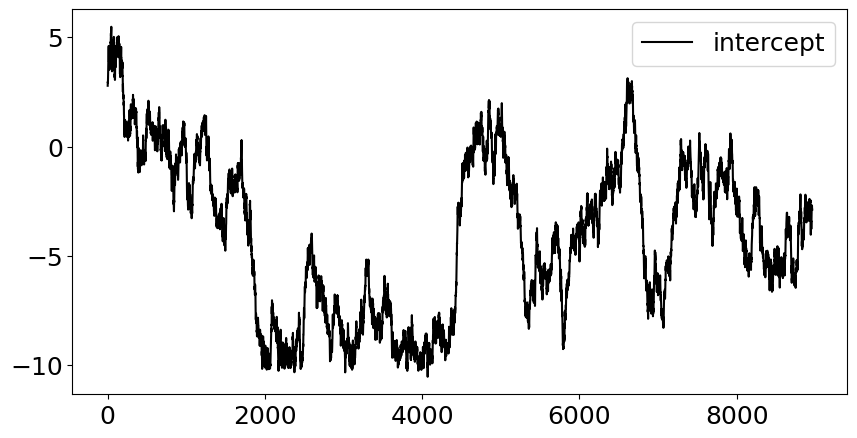

Fig 3:  intercept MCMC chain: the positions explored in the intercept direction of the posterior surface


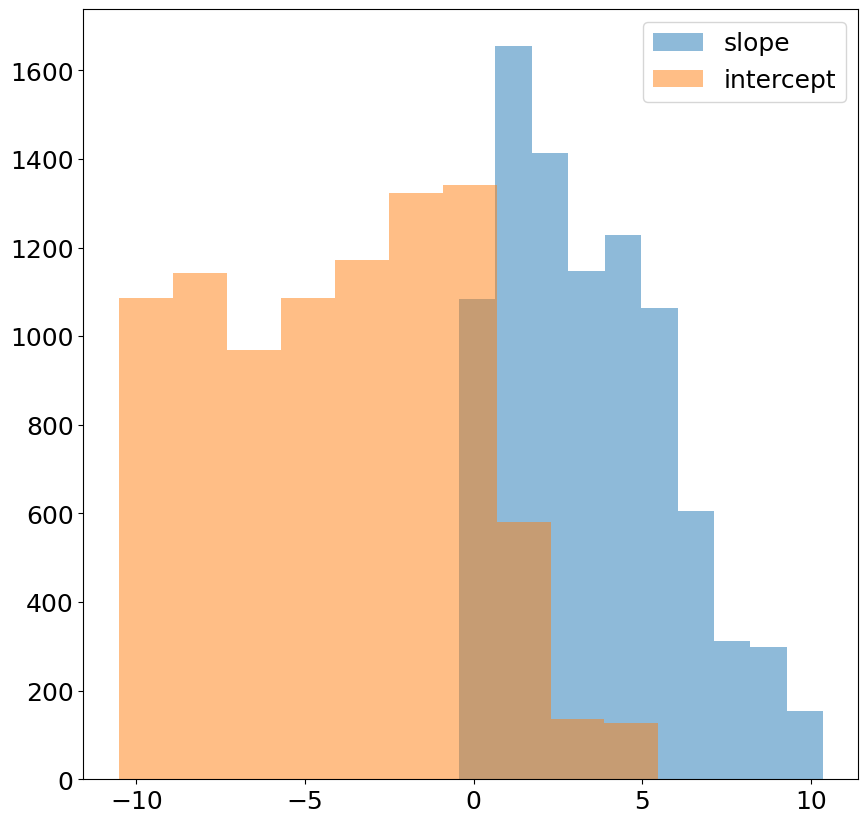

Fig 4:  distribution of position values for slope and intercept MCMC chains, i.e. the posterior distributions


In [13]:
# look at the sampled posterior  space
pl.figure(figsize=(10,5))
pl.plot(np.array(walk)[:,0],'k-', label="slope")
pl.legend()
pl.show()
print ("Fig 2:  slope MCMC chain: the positions explored in the slope direction of the posterior surface")

pl.figure(figsize=(10,5))
pl.plot(np.array(walk)[:,1], 'k-', label="intercept")
pl.legend()
pl.show()
print ("Fig 3:  intercept MCMC chain: the positions explored in the intercept direction of the posterior surface")

pl.figure()
pl.hist(np.array(walk)[:,0], alpha=0.5, label="slope")

pl.hist(np.array(walk)[:,1], alpha=0.5, label="intercept")
pl.legend()
pl.show()
print ("Fig 4:  distribution of position values for slope and intercept MCMC chains, i.e. the posterior distributions")


In [14]:
#here are all the positions in the chain, 2 values represent 2 coordinates in the slope-intercept space
walk

[array([2.62418808, 2.779966  ]),
 array([2.85888169, 2.96177562]),
 array([2.85180934, 2.9218932 ]),
 array([2.5658949 , 2.92958713]),
 array([2.41170939, 3.05216626]),
 array([2.19877517, 3.2589967 ]),
 array([2.02239082, 3.50965078]),
 array([2.02799416, 3.59136222]),
 array([1.67666912, 3.76028874]),
 array([1.73211309, 3.93086905]),
 array([1.77103301, 4.19299659]),
 array([1.62517537, 4.4648471 ]),
 array([1.4850522 , 4.60227469]),
 array([1.24307167, 4.59303815]),
 array([1.12081142, 4.42868785]),
 array([0.75734792, 4.14918002]),
 array([0.56038954, 3.87872366]),
 array([0.69448762, 4.02010986]),
 array([0.9804181 , 3.93729584]),
 array([0.71507356, 3.90753546]),
 array([0.90425824, 4.14835366]),
 array([0.81401009, 3.83086436]),
 array([0.82742402, 3.51265873]),
 array([0.2084499 , 4.19136208]),
 array([0.30344   , 4.18051918]),
 array([0.48180271, 4.3742529 ]),
 array([0.60796001, 4.19614892]),
 array([0.62441405, 4.18096081]),
 array([0.71035274, 4.20412075]),
 array([0.6014

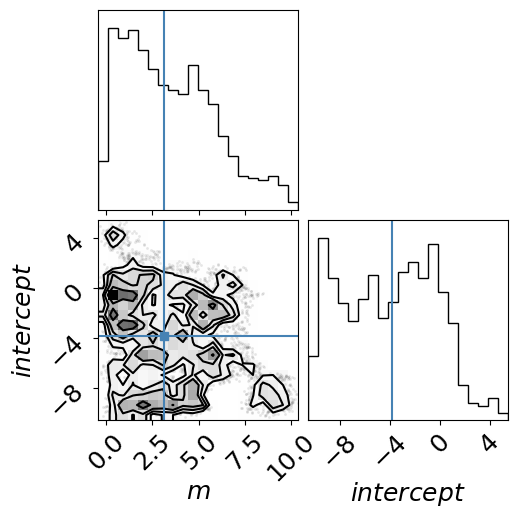

Fig 5: posterior joint distribution - generative model truth indicated in blue


In [16]:
fig = corner.corner(np.array(walk), labels=["$m$","$intercept$"],
                   truths=(m_mcmc[0], b_mcmc[0]))
pl.show()
print ("Fig 5: posterior joint distribution - generative model truth indicated in blue")

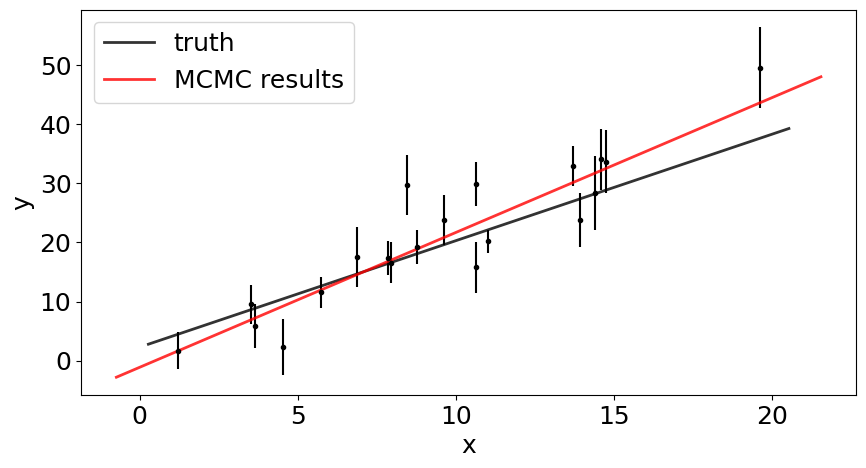

Figure 1: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors; the MCMC Metropolis Haesting results as the median of the posterior distribution


In [57]:

ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-', alpha=0.8, lw=2, label="truth")
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), 'r-', alpha=0.8, lw=2, label="MCMC results")
pl.legend()
pl.show()
print ("Figure 1: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors; the MCMC Metropolis Haesting results as the median of the posterior distribution")

# Affine Invariant MCMC sample (with emcee)

The emcee package implements Affine Invariant MCMC in python

https://emcee.readthedocs.io/en/stable/tutorials/quickstart/

In [62]:
# EMCEE needs a lnprob function to put together prior and posterior (in log space)
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [59]:
start = np.array([m_true, b_true])
ndim, nwalkers, nsteps = start.shape[0], 100, 500
pos = [start + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
pos

[array([1.80007317, 2.29998654]),
 array([1.80013392, 2.30008271]),
 array([1.79989699, 2.29992548]),
 array([1.80004746, 2.30013601]),
 array([1.79996658, 2.30006774]),
 array([1.79991474, 2.29976051]),
 array([1.80024962, 2.30020339]),
 array([1.80007788, 2.29998593]),
 array([1.80004051, 2.29990376]),
 array([1.80016014, 2.29997959]),
 array([1.79994296, 2.3001008 ]),
 array([1.79993031, 2.3001192 ]),
 array([1.80004794, 2.29998489]),
 array([1.80004031, 2.29995501]),
 array([1.79999698, 2.30013627]),
 array([1.79996187, 2.30004496]),
 array([1.79999619, 2.30006687]),
 array([1.80000983, 2.29994   ]),
 array([1.79990989, 2.29986848]),
 array([1.79997427, 2.29978635]),
 array([1.79986555, 2.30017956]),
 array([1.79973729, 2.29992622]),
 array([1.79994781, 2.30015525]),
 array([1.79984979, 2.30003087]),
 array([1.7999582, 2.2999964]),
 array([1.79996334, 2.2998912 ]),
 array([1.80008487, 2.30005892]),
 array([1.80005069, 2.30002268]),
 array([1.800072  , 2.29995971]),
 array([1.800013

The starting points for the walkers are set as a small perturbation on the initial guess


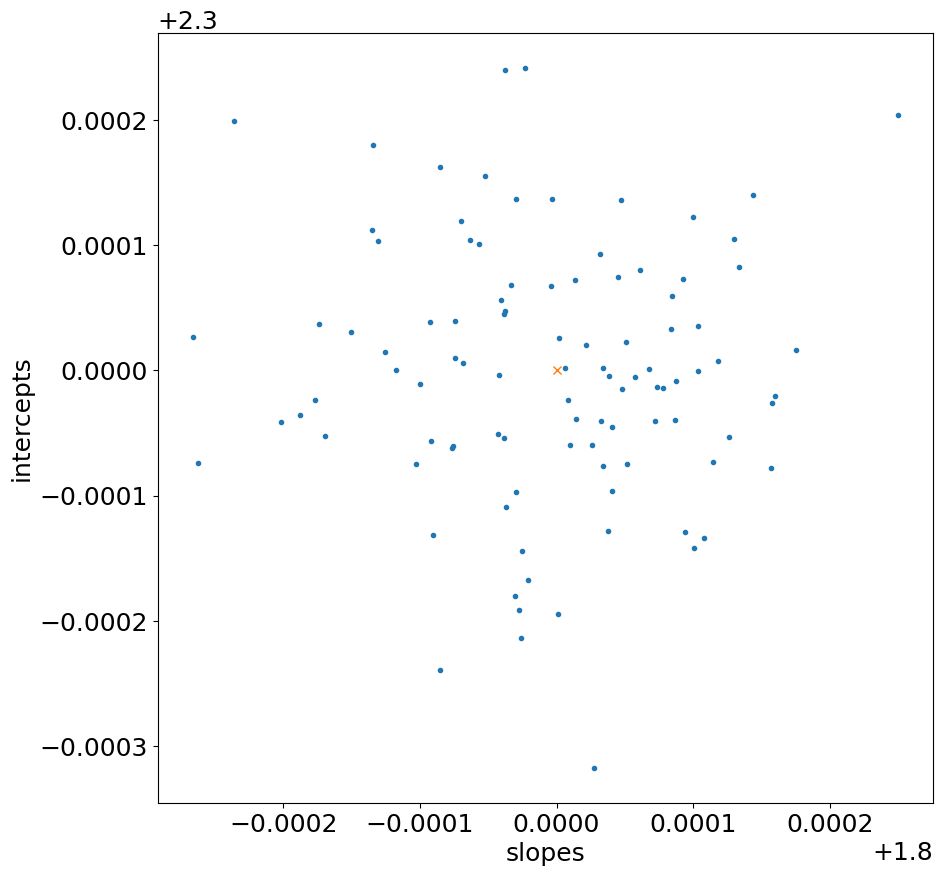

In [60]:
pl.plot(np.array(pos)[:,0], np.array(pos)[:,1], '.')
pl.plot(m_true, b_true, 'x')
pl.xlabel("slopes")
pl.ylabel("intercepts")
print("The starting points for the walkers are set as a small perturbation on the initial guess")

In [66]:
#create the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
#run the sampler model
sampler.run_mcmc(pos, nsteps);

In [67]:
#this creates 100 chains of 100 steaps each, each exploring 2 variables
sampler.chain.shape

(100, 500, 2)

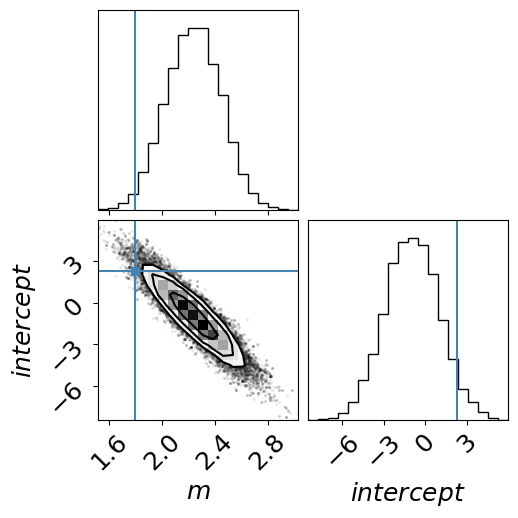

Fig 6: EMCEE with 100 chains of 100 steps  - generative model truth indicated in blue


In [68]:
#throw away the first 150 points and visualize the location of the chais at each step
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])
pl.show()
print ("Fig 6: EMCEE with {0:d} chains of {0:d} steps  ".format(nwalkers, nsteps) +
       "- generative model truth indicated in blue")

In [69]:
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [70]:
mcmcRes = np.concatenate([m_mcmc, b_mcmc])
print ("MCMC result:\nslope\t\t{0:+.2f} ({1:.2f}, {2:.2f})\nintercept\t{3:.2f} ({4:.2f}, {5:.2f})".format(*mcmcRes))

MCMC result:
slope		+2.24 (0.21, 0.21)
intercept	-0.96 (1.95, 1.92)


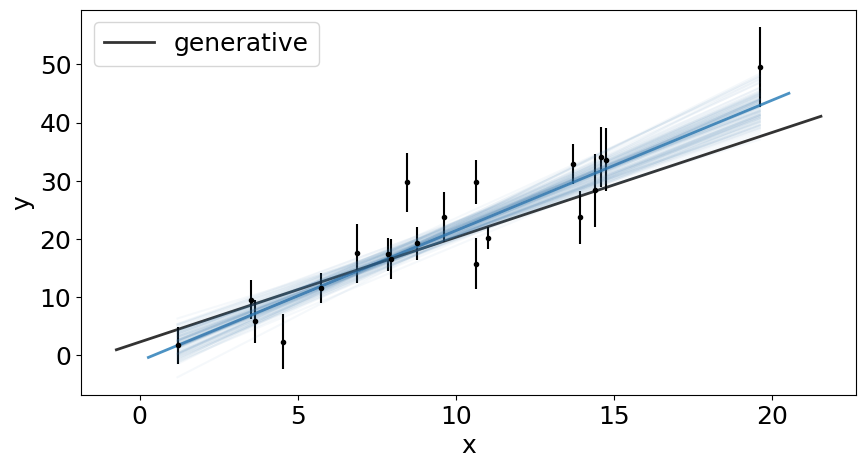

Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.
In blue model with the MCMC best fit parameters, identified as the median of the joint posterior distributions, is indicated.
In light blue shades the model with the best parameters for each chain is plotted


In [71]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), '-', alpha=0.8, lw=2)
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-',
        alpha=0.8, lw=2, label="generative")
for m, b in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, m*x+b, color="SteelBlue", alpha=0.05)
ax.legend(loc=2)
pl.show()
print ("Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.\n" +
       "In blue model with the MCMC best fit parameters, "  +
       "identified as the median of the joint posterior distributions, is indicated.\n" +
       "In light blue shades the model with the best parameters for each chain is plotted")

# Comparison with analytical solution

In [72]:
# linear algebra solution
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.
In blue model with the MCMC best fit parameters, identified as the median of the joint posterior distributions, is indicated.
In light blue shades the model with the best parameters for each chain is plotted
In orange the anayltical solution (OLS) is indicated by a dashed line


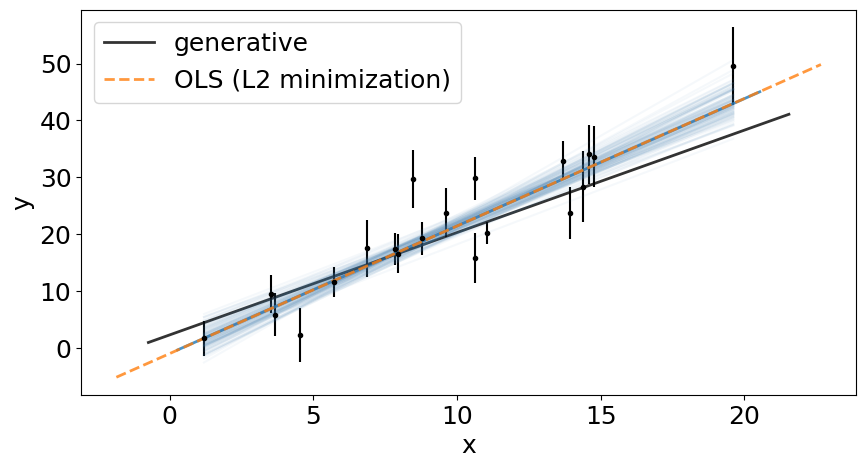

In [73]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), '-', alpha=0.8, lw=2)
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-',
        alpha=0.8, lw=2, label="generative")
for m, b in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, m*x+b, color="SteelBlue", alpha=0.05)
ax.plot(pl.xlim(), line(m_ls, b_ls,  np.array(pl.xlim())), '--',
        alpha=0.8, lw=2, label="OLS (L2 minimization)")
pl.legend();
print ("Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.\n" +
       "In blue model with the MCMC best fit parameters, "  +
       "identified as the median of the joint posterior distributions, is indicated.\n" +
       "In light blue shades the model with the best parameters for each chain is plotted\n" +
       "In orange the anayltical solution (OLS) is indicated by a dashed line")

In [74]:
pos = [np.array([m_ls, b_ls]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, nsteps);

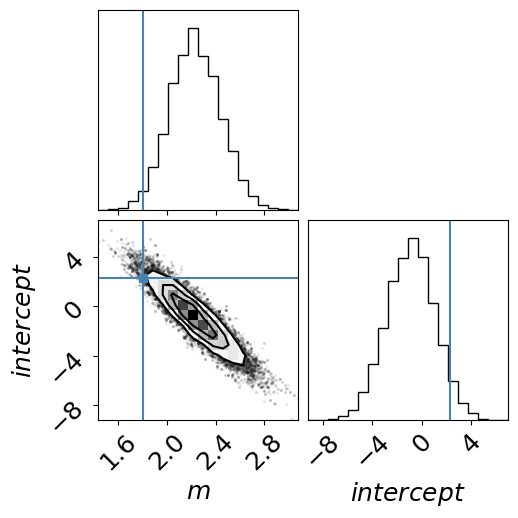

Fig 10: EMCEE with 100 chains of 100 steps  - generative model truth indicated in blue, the starting point was the OLS solution


In [75]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])
pl.show()
print ("Fig 10: EMCEE with 100 chains of 100 steps  - generative model truth indicated in blue, the starting point was the OLS solution")


In [76]:
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
mcmcRes = np.concatenate([m_mcmc, b_mcmc])
print ("MCMC result:\nslope\t\t{0:+.2f} ({1:.2f}, {2:.2f})\nintercept\t{3:.2f} ({4:.2f}, {5:.2f})".format(*mcmcRes))

MCMC result:
slope		+2.23 (0.21, 0.20)
intercept	-0.88 (1.92, 1.97)


# Test convergence by looking at the autocorrelation

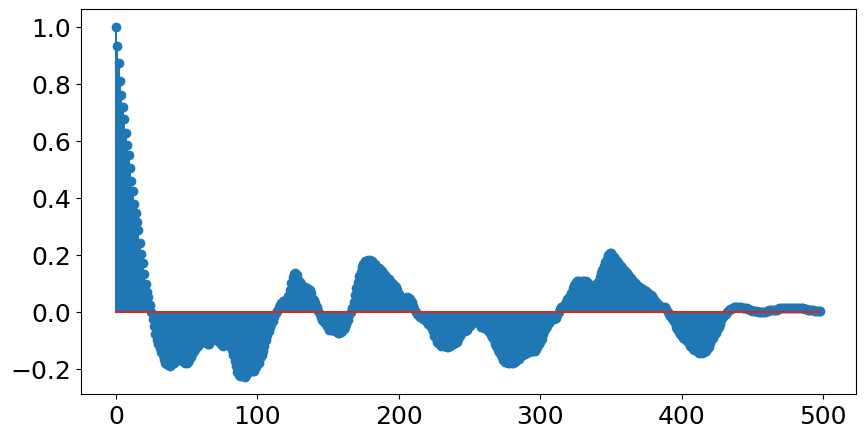

Fig 11: Chain Autocorrelation


In [77]:
def acorr(x):
    ax = pl.figure(figsize=(10,5)).add_subplot(111)

    x = x - x.mean()

    autocorr = np.correlate(x, x, mode='full')
    autocorr = autocorr[x.size:]
    autocorr /= autocorr.max()

    return ax.stem(autocorr)

acorr(sampler.chain[0,:,0])
pl.show()
print ("Fig 11: Chain Autocorrelation")

# Increase the steps in the chain

In [78]:
ndim, nwalkers, nsteps = 2, 100, 1500
pos = [np.array([m_ls, b_ls]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 1500);

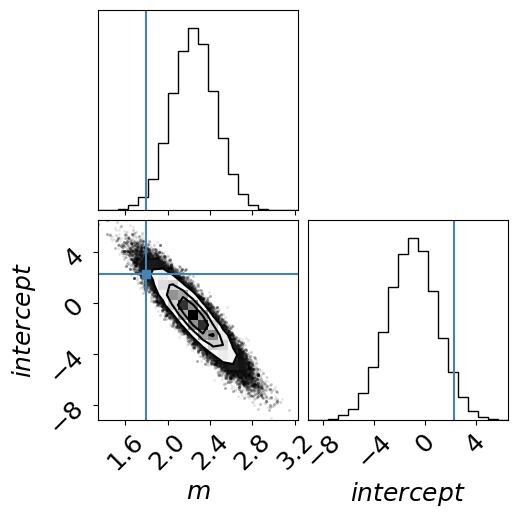

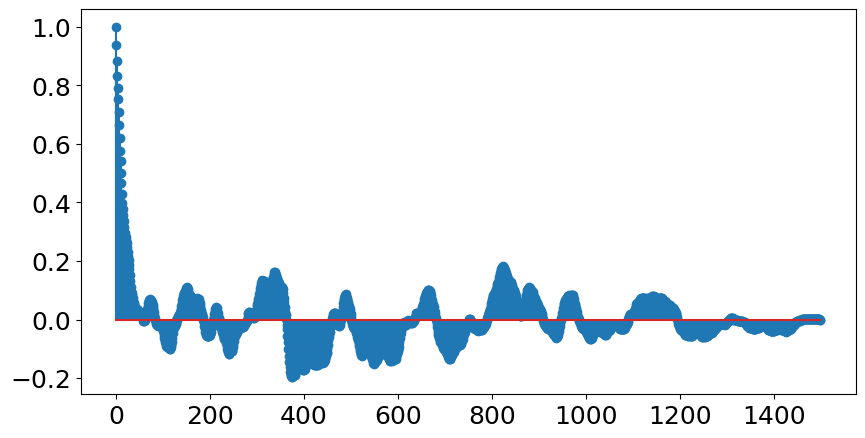

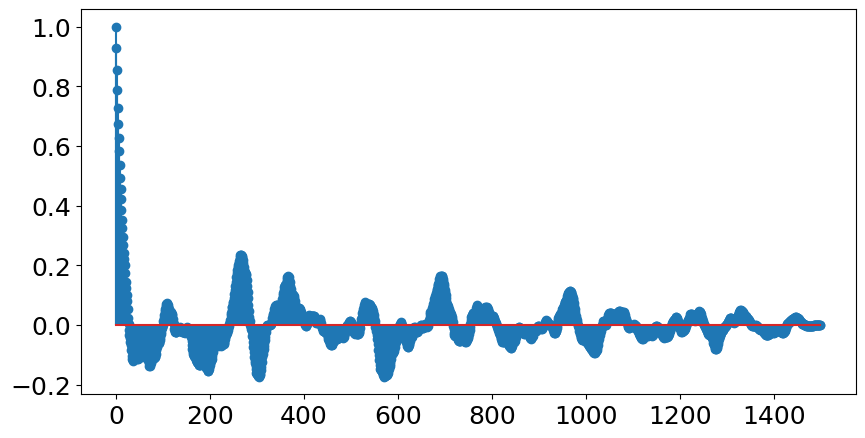

Fig 12: Corner plot showing the joint posterior and chain autocorrelation for 2 longer chain of 1500 steps


In [79]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
m_mcmc, b_mcmc

acorr(sampler.chain[0,:,0])
acorr(sampler.chain[1,:,0])
pl.show()
print ("Fig 12: Corner plot showing the joint posterior and chain autocorrelation for 2 longer chain of %d steps"%nsteps)

#Add a parameter that represents the possibility that your uncertainties are  underestimated?
read section 6 https://arxiv.org/pdf/1008.4686.pdf

this example is developed here https://emcee.readthedocs.io/en/stable/tutorials/line/



a linear model

$\log{p(\vec{y}|\vec{x},\vec{y_{err}}, m,b)} \propto -\frac{1}{2}\sum_i {\frac{(y_i-(mx_i + b))^2}{y_{err,i}^2}}$

a linear model where the quoted uncertainties are underestimated by a constant fractional amount

$s^2 = y_{err}^2 + a^2(mx+b)^2$

$\log{p(\vec{y}|\vec{x},\vec{y_{err}}, m,b,a)} \propto -\frac{1}{2}\sum_i \left({\frac{(y_i-(mx_i + b))^2}{s_i^2}} + \log (2\pi s_i^2)\right)$

In [86]:

def lnlike(theta, x, y, yerr):

    m, b, a = theta
    s2 = yerr ** 2 + line(m, b, x) ** 2 * a**2
    #return -0.5*(np.sum((line(m, b, x) - y)**2 / (s**2) + np.log(2*np.pi*s**2)))
    return -0.5*(np.sum((line(m, b, x) - y)**2 / (s2) + np.log(s2)))

In [87]:
def lnprior(theta):
    m, b, a = theta
    if -10 < b < 10 and 0 < m < 10 and a >= 0:
        return 0.0
    return -np.inf

In [88]:
ndim, nwalkers, nsteps = 3, 100, 1500
pos = [np.array([m_ls, b_ls, 0.01]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 1500);

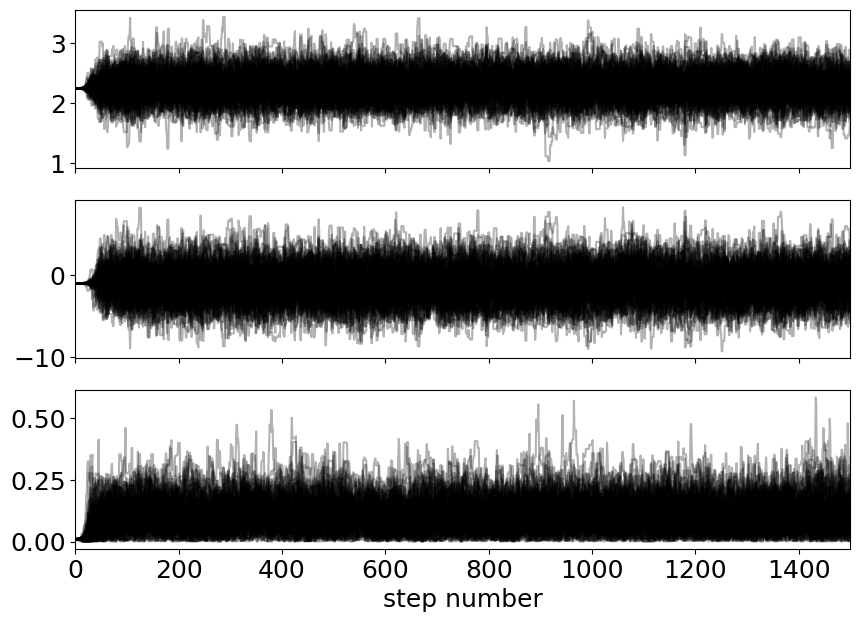

In [89]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [90]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
np.percentile(samples, [50], axis=0)

array([[ 2.28379124, -1.10593053,  0.10046692]])

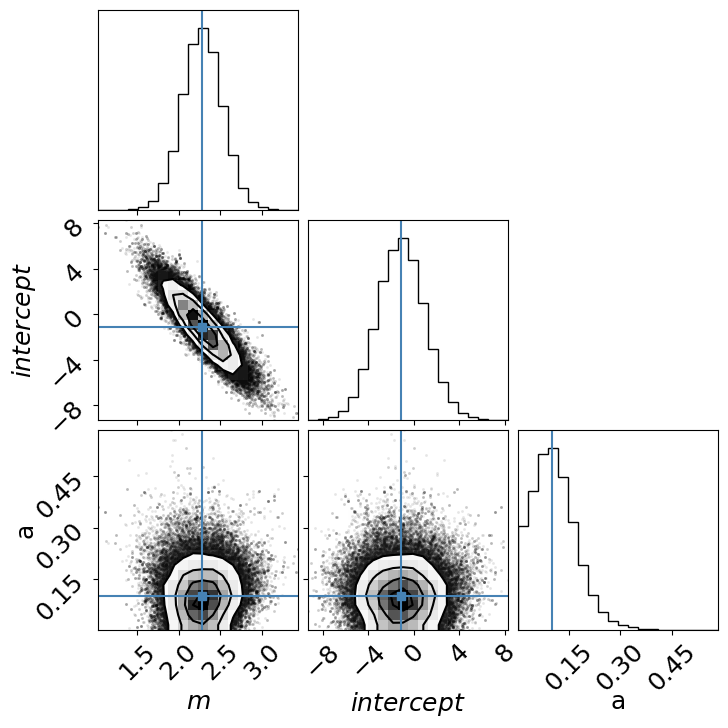

In [91]:
fig = corner.corner(samples, labels=["$m$","$intercept$", "a"],
                      truths=np.percentile(samples, [50],
                                               axis=0)[0]
                       )
m_mcmc, b_mcmc, a_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
pl.show()
